In [62]:
import matplotlib.pyplot as plt
import numpy as np
import beamtools.distributions as btd
import beamtools.fitting as btf
import beamtools.statistics as bts
import time

In [63]:
# Parameter range of betatronic distribution
x0 = np.arange(-20,20,0.1)
q0s = np.arange(0.5, 1.6, 0.03)
sigma0qs = np.arange(0.2, 2.7, 0.05)

In [64]:
# Realistic dispersive distribution
[xdreal, ydreal] = np.load('example_data/PSB_LIUWS_R3H_tomoscope.npy')
dispersion_m = 1.4689*1.0
poptd, _, _, xgaussian_d, ygaussian_d = btf.makeGaussianFit_5_parameters(xdreal*dispersion_m*1e3,ydreal)
qd0 = 0.8 # just a guess of overpopulated tails
p0 = [poptd[1], qd0,  1/poptd[2]**2/(5-3*qd0), poptd[0], poptd[3], poptd[4]] # mu, q, beta, A, offset, slope
poptqd, _, _, xqgaussian_d, yqgaussian_d = btf.makeQGaussianFit_6p(xdreal*dispersion_m*1e3,ydreal,p0)
qd = poptqd[1]
#sigmad = np.sqrt(1/(5-3*qd)/poptqd[2])
sigmad,_ = bts.findSigma(xdreal*dispersion_m*1e3, ydreal)
print('Dispersive distribution: qd=%1.2f, sigmad=%1.2f'%(qd,sigmad))
xd = np.copy(x0)
yd = btd.qgauss(xd, mu=0, q=qd, beta=1/(5-3*qd)/sigmad**2, A=1)
yd = yd/np.trapz(yd, xd) # normalize area to 1

Dispersive distribution: qd=0.01, sigmad=2.33


In [65]:
# Loop
start_time = time.time()
_q0 = np.zeros((len(q0s),len(sigma0qs)))
_sigma0q = np.zeros((len(q0s),len(sigma0qs)))
_sigma0 = np.zeros((len(q0s),len(sigma0qs)))
_qm = np.zeros((len(q0s),len(sigma0qs)))
_sigmamq = np.zeros((len(q0s),len(sigma0qs)))
_sigmam = np.zeros((len(q0s),len(sigma0qs)))
for i,q0 in enumerate(q0s):
    for j,sigma0q in enumerate(sigma0qs):

        _q0[i,j] = q0
        _sigma0q[i,j] = sigma0q

        # Betatronic distribution (q-Gaussian)
        y0 = btd.qgauss(x0, mu=0, q=q0, beta=1/(5-3*q0)/sigma0q**2, A=1)
        y0 = y0/np.trapz(y0, x0) # normalize area to 1
        popt0, _, _, _, _ = btf.makeGaussianFit(x0, y0)
        _sigma0[i,j] = popt0[2]

        # Measured distribution (numerical convolution)
        xm = np.copy(x0)
        ym = np.convolve(y0, yd, mode='same')
        ym = ym/np.trapz(ym, x0) # normalize area to 1
        poptm, _, _, _, _ = btf.makeGaussianFit(xm,ym)
        _sigmam[i,j] = poptm[2]
        qm0 = q0 # just a guess of overpopulated tails
        p0 = [poptm[1], qm0,  1/poptm[2]**2/(5-3*q0), poptm[0]] # mu, q, beta, A
        poptqm, _, _, _, _ = btf.makeQGaussianFit(xm,ym,p0)
        _qm[i,j] = poptqm[1]
        _sigmamq[i,j] = 1/np.sqrt(poptqm[2]*(5-3*poptqm[1]))
end_time = time.time()
print('Elapsed time: %1.2f s'%(end_time-start_time))

/home/tprebiba/python_environments/base-2022/miniconda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/eos/home-t/tprebiba/Fellowship/scripts/beam-analysis-sandbox/beamtools/beamtools/distributions.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return (2*sqrt(pi))/((3-q)*sqrt(1-q))*(Gamma((1)/(1-q)))/(Gamma((3-q)/(2*(1-q))))
/eos/home-t/tprebiba/Fellowship/scripts/beam-analysis-sandbox/beamtools/beamtools/distributions.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return (sqrt(pi))/(sqrt(q-1))*(Gamma((3-q)/(2*(q-1))))/(Gamma((1)/(q-1)))
/eos/home-t/tprebiba/Fellowship/scripts/beam-analysis-sandbox/beamtools/beamtools/distributions.py:55: RuntimeWarning: invalid value encountered in sqrt
  return A*np.sqrt(beta)/C_q(q)*e_q(-beta*(x-mu)**2,q)


Elapsed time: 31.09 s


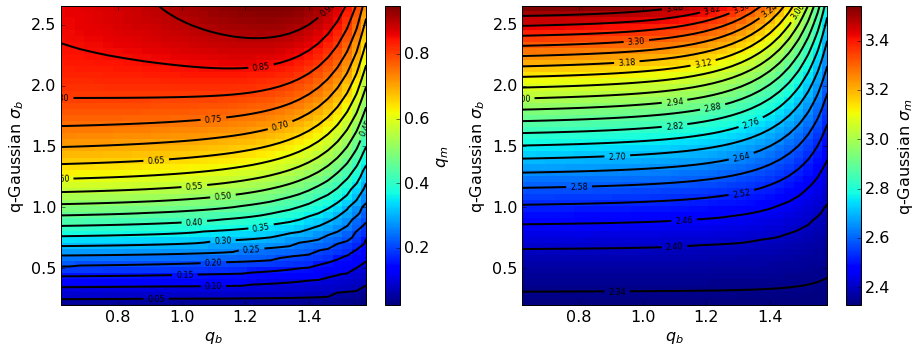

In [66]:
# Plot q0 vs. sigma0q vs. qm and q0 vs. sigma0q vs. sigmamq
mask = np.where((_q0>0.6) & (_q0<1.6))[0]
#mask = np.where((_q0>0.6) & (_q0<1.6) & (_sigma0q>0.3) & (_sigma0q<3.6))[0]

f,axs = plt.subplots(1,2,figsize=(13,5))
fontsize=16
ms = 100
lw=2
levels=20

ax = axs[0]
ax.set_xlabel(r"$q_b$", fontsize=fontsize)
ax.set_ylabel(r"q-Gaussian $\sigma_b$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc = ax.scatter(_q0[mask], _sigma0q[mask], c=_qm[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour1 = ax.contour(_q0[mask], _sigma0q[mask], _qm[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour1, inline=True, fontsize=8)
cbar1 = plt.colorbar(sc)
cbar1.ax.tick_params(labelsize=fontsize)
cbar1.set_label(r"$q_m$", fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$q_b$", fontsize=fontsize)
ax.set_ylabel(r"q-Gaussian $\sigma_b$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc2 = plt.scatter(_q0[mask], _sigma0q[mask], c=_sigmamq[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour2 = ax.contour(_q0[mask], _sigma0q[mask], _sigmamq[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour2, inline=True, fontsize=8)
cbar2 = plt.colorbar(sc2)
cbar2.ax.tick_params(labelsize=fontsize)
cbar2.set_label(r"q-Gaussian $\sigma_m$", fontsize=fontsize)

plt.tight_layout()
plt.show()

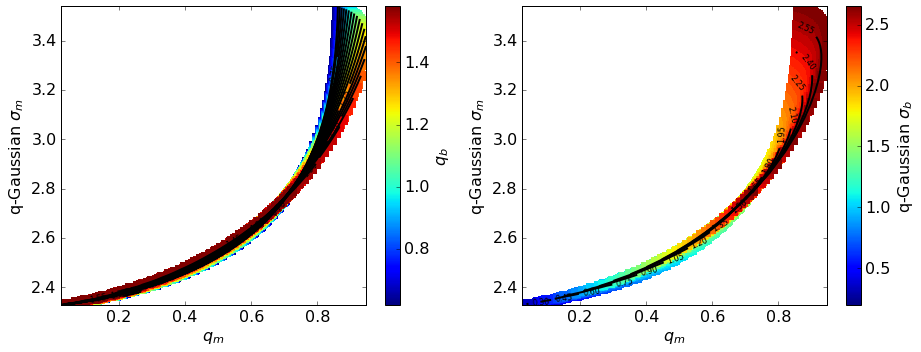

In [67]:
# Plot qm vs. sigmamq vs. q0 and qm vs. sigmamq vs. sigma0q
mask = np.where((_q0>0.6) & (_q0<1.6))[0]

f, axs = plt.subplots(1, 2, figsize=(13, 5))
fontsize = 16
ms = 100
lw = 2

ax = axs[0]
ax.set_xlabel(r"$q_m$", fontsize=fontsize)
ax.set_ylabel(r"q-Gaussian $\sigma_m$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc = ax.scatter(_qm[mask], _sigmamq[mask], c=_q0[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour1 = ax.contour(_qm[mask], _sigmamq[mask], _q0[mask], colors='black', linewidths=lw, levels=20)
plt.clabel(contour1, inline=True, fontsize=8)
cbar1 = plt.colorbar(sc)
cbar1.ax.tick_params(labelsize=fontsize)
cbar1.set_label(r"$q_b$", fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$q_m$", fontsize=fontsize)
ax.set_ylabel(r"q-Gaussian $\sigma_m$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc2 = ax.scatter(_qm[mask], _sigmamq[mask], c=_sigma0q[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour2 = ax.contour(_qm[mask], _sigmamq[mask], _sigma0q[mask], colors='black', linewidths=lw, levels=20)
plt.clabel(contour2, inline=True, fontsize=8)
cbar2 = plt.colorbar(sc2)
cbar2.ax.tick_params(labelsize=fontsize)
cbar2.set_label(r"q-Gaussian $\sigma_b$", fontsize=fontsize)

plt.tight_layout()
plt.show()

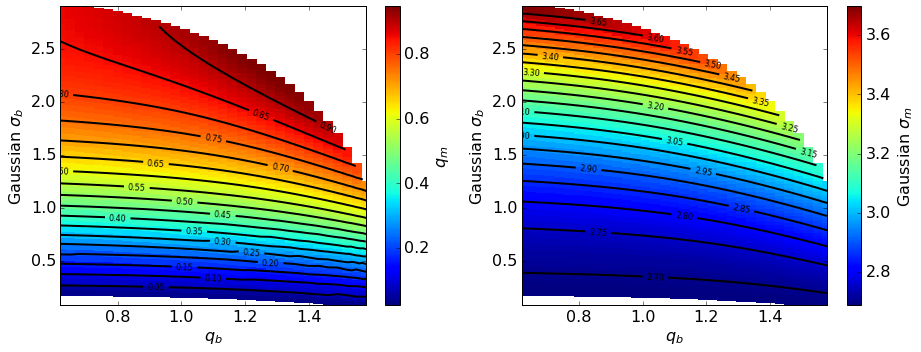

In [68]:
# Plot q0 vs. sigma0 vs. qm and q0 vs. sigma0 vs. sigmam
mask = np.where((_q0>0.6) & (_q0<1.6))[0]
#mask = np.where((_q0>0.6) & (_q0<1.6) & (_sigma0q>0.3) & (_sigma0q<3.6))[0]

f,axs = plt.subplots(1,2,figsize=(13,5))
fontsize=16
ms = 100
lw=2
levels=20

ax = axs[0]
ax.set_xlabel(r"$q_b$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\sigma_b$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc = ax.scatter(_q0[mask], _sigma0[mask], c=_qm[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour1 = ax.contour(_q0[mask], _sigma0[mask], _qm[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour1, inline=True, fontsize=8)
cbar1 = plt.colorbar(sc)
cbar1.ax.tick_params(labelsize=fontsize)
cbar1.set_label(r"$q_m$", fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$q_b$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\sigma_b$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc2 = plt.scatter(_q0[mask], _sigma0[mask], c=_sigmam[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour2 = ax.contour(_q0[mask], _sigma0[mask], _sigmam[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour2, inline=True, fontsize=8)
cbar2 = plt.colorbar(sc2)
cbar2.ax.tick_params(labelsize=fontsize)
cbar2.set_label(r"Gaussian $\sigma_m$", fontsize=fontsize)

plt.tight_layout()
plt.show()

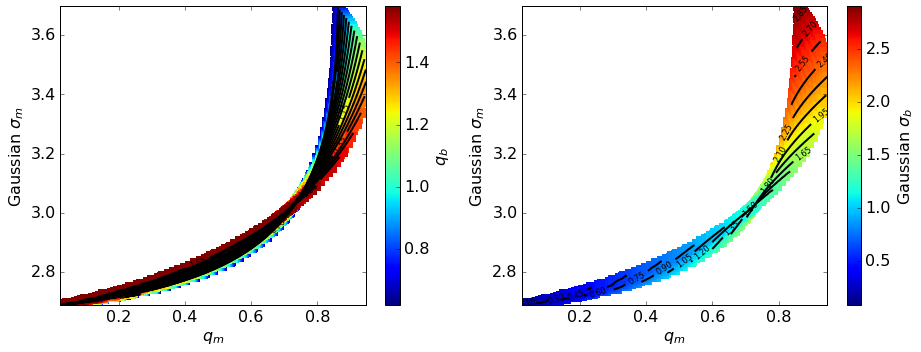

In [69]:
# Plot qm vs. sigmam vs. q0 and qm vs. sigmam vs. sigma0
mask = np.where((_q0>0.6) & (_q0<1.6))[0]
#mask = np.where((_q0>0.6) & (_q0<1.6) & (_sigma0q>0.3) & (_sigma0q<3.6))[0]

f,axs = plt.subplots(1,2,figsize=(13,5))
fontsize=16
ms = 100
lw=2
levels=20

ax = axs[0]
ax.set_xlabel(r"$q_m$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\sigma_m$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc = ax.scatter(_qm[mask], _sigmam[mask], c=_q0[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour1 = ax.contour(_qm[mask], _sigmam[mask], _q0[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour1, inline=True, fontsize=8)
cbar1 = plt.colorbar(sc)
cbar1.ax.tick_params(labelsize=fontsize)
cbar1.set_label(r"$q_b$", fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$q_m$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\sigma_m$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc2 = plt.scatter(_qm[mask], _sigmam[mask], c=_sigma0[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour2 = ax.contour(_qm[mask], _sigmam[mask], _sigma0[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour2, inline=True, fontsize=8)
cbar2 = plt.colorbar(sc2)
cbar2.ax.tick_params(labelsize=fontsize)
cbar2.set_label(r"Gaussian $\sigma_b$", fontsize=fontsize)

plt.tight_layout()
plt.show()

In [70]:
# Emittance
betax = 5.7916
beta_rel = 0.95
gamma_rel = 3.14
_epsilon0 = _sigma0**2/betax*beta_rel*gamma_rel
_epsilonm = (_sigmam**2-sigmad**2)/betax*beta_rel*gamma_rel

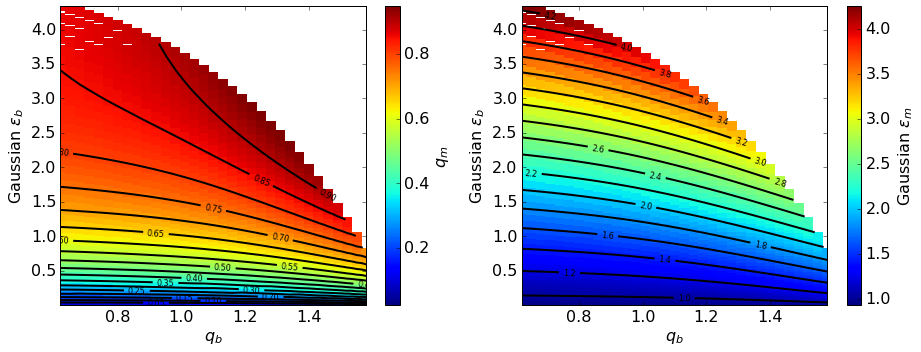

In [71]:
# Plot q0 vs. epsilon0 vs. qm and q0 vs. epsilon0 vs. epsilonm
mask = np.where((_q0>0.6) & (_q0<1.6))[0]
#mask = np.where((_q0>0.6) & (_q0<1.6) & (_sigma0q>0.3) & (_sigma0q<3.6))[0]

f,axs = plt.subplots(1,2,figsize=(13,5))
fontsize=16
ms = 100
lw=2
levels=20

ax = axs[0]
ax.set_xlabel(r"$q_b$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\epsilon_b$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc = ax.scatter(_q0[mask], _epsilon0[mask], c=_qm[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour1 = ax.contour(_q0[mask], _epsilon0[mask], _qm[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour1, inline=True, fontsize=8)
cbar1 = plt.colorbar(sc)
cbar1.ax.tick_params(labelsize=fontsize)
cbar1.set_label(r"$q_m$", fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$q_b$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\epsilon_b$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc2 = plt.scatter(_q0[mask], _epsilon0[mask], c=_epsilonm[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour2 = ax.contour(_q0[mask], _epsilon0[mask], _epsilonm[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour2, inline=True, fontsize=8)
cbar2 = plt.colorbar(sc2)
cbar2.ax.tick_params(labelsize=fontsize)
cbar2.set_label(r"Gaussian $\epsilon_m$", fontsize=fontsize)

plt.tight_layout()
plt.show()

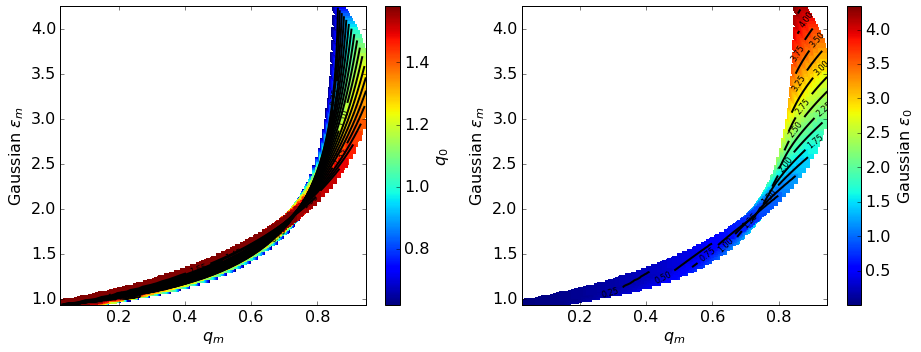

In [72]:
# Plot qm vs. epsilonm vs. q0 and qm vs. epsilonm vs. epsilon0
mask = np.where((_q0>0.6) & (_q0<1.6))[0]
#mask = np.where((_q0>0.6) & (_q0<1.6) & (_sigma0q>0.3) & (_sigma0q<3.6))[0]

f,axs = plt.subplots(1,2,figsize=(13,5))
fontsize=16
ms = 100
lw=2
levels=20

ax = axs[0]
ax.set_xlabel(r"$q_m$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\epsilon_m$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc = ax.scatter(_qm[mask], _epsilonm[mask], c=_q0[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour1 = ax.contour(_qm[mask], _epsilonm[mask], _q0[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour1, inline=True, fontsize=8)
cbar1 = plt.colorbar(sc)
cbar1.ax.tick_params(labelsize=fontsize)
cbar1.set_label(r"$q_0$", fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$q_m$", fontsize=fontsize)
ax.set_ylabel(r"Gaussian $\epsilon_m$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sc2 = plt.scatter(_qm[mask], _epsilonm[mask], c=_epsilon0[mask], cmap='jet', marker='s', s=ms, edgecolors='none')
contour2 = ax.contour(_qm[mask], _epsilonm[mask], _epsilon0[mask], colors='black', linewidths=lw, levels=levels)
plt.clabel(contour2, inline=True, fontsize=8)
cbar2 = plt.colorbar(sc2)
cbar2.ax.tick_params(labelsize=fontsize)
cbar2.set_label(r"Gaussian $\epsilon_0$", fontsize=fontsize)

plt.tight_layout()
plt.show()